In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from sklearn.mixture import GaussianMixture 
#import testing
import sys
sys.path.append("../../")
import selection_tests

import itertools

In [2]:
data = pd.read_stata("../all_plans_c_bonus.dta")
data['log_enroll'] = np.log(data['enr_c'])
data['enr_total'] = data['enr_c'] + data['enr_FFS']
data['penetration'] = data['enr_c']/data['enr_total']

#create a variable that is just db 
treat = data[['ssa', 'state', 'county', 'double_bonus']].copy()
treat = treat.groupby(['ssa', 'state', 'county'],as_index=False).max()
treat = treat.rename(columns={'double_bonus':'treatment' })


print(treat)
print(data.shape)
data = data.merge(treat, on=['ssa', 'state', 'county'],how='left')

        ssa state      county  treatment
0      1000    AL     Autauga          1
1      1010    AL     Baldwin          1
2      1020    AL     Barbour          0
3      1030    AL        Bibb          1
4      1040    AL      Blount          1
...     ...   ...         ...        ...
2966  53180    WY  Sweetwater          0
2967  53190    WY       Teton          0
2968  53200    WY       Uinta          0
2969  53210    WY    Washakie          0
2970  53220    WY      Weston          0

[2971 rows x 4 columns]
(32702, 83)


/tmp/ipykernel_32614/4048899732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


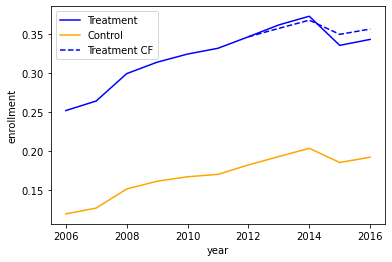

(    year  penetration   enr_total  treatment         y
 0   2006   150.399277  25179618.0          0  0.119844
 1   2007   188.256378  26031686.0          0  0.127355
 2   2008   261.584442  26609852.0          0  0.151817
 3   2009   280.544312  26945392.0          0  0.161753
 4   2010   292.551819  27459440.0          0  0.167480
 5   2011   284.723389  27899786.0          0  0.170567
 6   2012   303.461426  28875432.0          0  0.182657
 7   2013   322.626984  29670032.0          0  0.193419
 8   2014   328.212982  29868524.0          0  0.203959
 9   2015   289.700684  35193808.0          0  0.185762
 10  2016   300.299469  36045652.0          0  0.192565,
     year  penetration   enr_total         y
 0   2006    57.963585   7252935.0  0.252386
 1   2007    62.729111   7374281.0  0.264672
 2   2008    73.939537   7319448.0  0.299738
 3   2009    78.672867   7391350.0  0.314406
 4   2010    81.944366   7533377.0  0.324845
 5   2011    83.640968   7695250.0  0.332269
 6   2012   

In [3]:
def create_plot_y(df):
    df = df.copy()
    df['y'] = df['penetration']*df['enr_total']
    df_group = df.groupby('year',as_index=False).sum()
    df_group['y'] = df_group['y']/df_group['enr_total']
    return df_group.copy()


def create_synth_plot(data,intervention,begin,end,name):    
    #treatment
    data_treat = data[(data['treatment']==1) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['penetration','year','enr_total']]
    data_treat =  create_plot_y(data_treat)
    plt.plot(data_treat['year'],data_treat['y'],label='Treatment',color='blue')

    
    #control
    data_control  = data[ (data['treatment']==0) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['penetration','year','enr_total','treatment']]
    data_control =  create_plot_y(data_control)
    plt.plot(data_control['year'],data_control['y'],label='Control',color='orange')
    

    #treat cf
    data_treat_cf = data_control[ (data_control['year']>=intervention) & (data_control['year']<=end)]
    diff = (data_treat['y'][data_treat['year']==intervention].mean() - 
                data_control['y'][data_control['year']==intervention].mean())
    data_treat_cf['y'] = data_treat_cf['y'] + diff
    
        
    plt.plot(data_treat_cf['year'],data_treat_cf['y'],label='Treatment CF',color='blue',linestyle='--')

    plt.xlabel('year')
    plt.ylabel('enrollment')
    plt.legend()
    plt.savefig(name,dpi=300)
    plt.show()
    return data_control, data_treat, data_treat_cf
    
create_synth_plot(data,2012,2006,2016,'double_bonus_intervention.png')

/tmp/ipykernel_32614/4048899732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


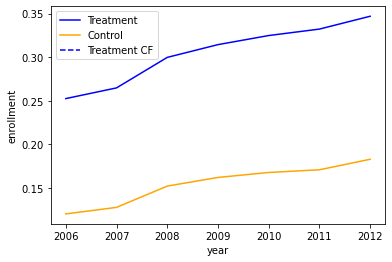

(   year  penetration   enr_total  treatment         y
 0  2006   150.399277  25179618.0          0  0.119844
 1  2007   188.256378  26031686.0          0  0.127355
 2  2008   261.584442  26609852.0          0  0.151817
 3  2009   280.544312  26945392.0          0  0.161753
 4  2010   292.551819  27459440.0          0  0.167480
 5  2011   284.723389  27899786.0          0  0.170567
 6  2012   303.461426  28875432.0          0  0.182657,
    year  penetration  enr_total         y
 0  2006    57.963585  7252935.0  0.252386
 1  2007    62.729111  7374281.0  0.264672
 2  2008    73.939537  7319448.0  0.299738
 3  2009    78.672867  7391350.0  0.314406
 4  2010    81.944366  7533377.0  0.324845
 5  2011    83.640968  7695250.0  0.332269
 6  2012    87.334106  8040747.0  0.347026,
    year  penetration   enr_total  treatment         y
 6  2012   303.461426  28875432.0          0  0.347026)

In [4]:
create_synth_plot(data,2012,2006,2012,'double_bonus_intervention-zoom.png')

In [5]:
print(data['bm_ns'].mean())
print(data['bmFFS'].mean())
print(data['benchmark_diff_ns'].mean())
print(data['bm_ns']-data['bmFFS'])

818.4683227539062
829.761474609375
-5.740026950836182
0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
32697   -58.529480
32698   -37.839966
32699     0.000000
32700     0.000000
32701     0.000000
Length: 32702, dtype: float32


In [6]:
cutoff1 = 10
cutoff2 = 3

#make a new treatment var...
data_bm = data.copy()
data_bm = data_bm.drop(['treatment'],axis=1)

treat = data[['ssa', 'state', 'county', 'bm_ns']].copy()
treat_2011 = data[['ssa', 'state', 'county', 'bm_ns']][data['year']==2011]
treat_2011 = treat_2011.groupby(['ssa', 'state', 'county'],as_index=False).max()

treat_2012 = data[['ssa', 'state', 'county', 'bm_ns']][data['year']==2012]
treat_2012 = treat_2012.groupby(['ssa', 'state', 'county'],as_index=False).max()


treat_2012_2 = data[['ssa', 'state', 'county', 'bmFFS']][data['year']==2012]
treat_2012_2 = treat_2012_2.groupby(['ssa', 'state', 'county'],as_index=False).max()

treat = treat_2011.merge(treat_2012,on=['ssa', 'state', 'county'],suffixes=('_2011', '_2012'))
treat = treat.merge(treat_2012_2,on=['ssa', 'state', 'county'])




print(data_bm.shape)
data_bm = data_bm.merge(treat, on=['ssa', 'state', 'county'],how='left',suffixes=('','_2012'))
print(data_bm.shape)

data_bm['treatment_1'] = 100*(data_bm['bm_ns_2011'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2011'] 
data_bm['treatment_2'] = 100*(data_bm['bmFFS_2012'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2012'] 
data_bm['treatment'] =  (data_bm['treatment_1'] > cutoff1 )*(data_bm['treatment_2'] < cutoff2)
#data_bm['treatment_1']  + 2 >= data_bm['treatment_2'] 
print(data_bm[['bm_ns_2011','bm_ns_2012','bmFFS_2012','treatment_1','treatment_2','treatment']])

#bm 5_star with some percent of bm cut

(32702, 83)
(32702, 86)
       bm_ns_2011  bm_ns_2012  bmFFS_2012  treatment_1  treatment_2  treatment
0      863.221558  810.012573  824.830750     6.164001     1.829376      False
1      863.221558  810.012573  824.830750     6.164001     1.829376      False
2      863.221558  810.012573  824.830750     6.164001     1.829376      False
3      863.221558  810.012573  824.830750     6.164001     1.829376      False
4      863.221558  810.012573  824.830750     6.164001     1.829376      False
...           ...         ...         ...          ...          ...        ...
32697  781.972595  756.370239  778.278259     3.274073     2.896468      False
32698  781.972595  756.370239  778.278259     3.274073     2.896468      False
32699  781.972595  756.370239  778.278259     3.274073     2.896468      False
32700  781.972595  756.370239  778.278259     3.274073     2.896468      False
32701  781.972595  756.370239  778.278259     3.274073     2.896468      False

[32702 rows x 6 columns]


/tmp/ipykernel_32614/4048899732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


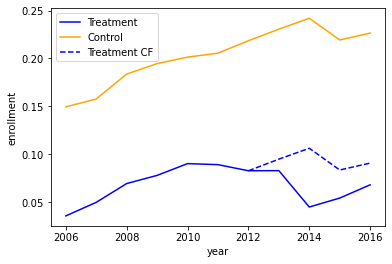

0     0.035736
1     0.049891
2     0.069501
3     0.078011
4     0.090292
5     0.089234
6     0.082853
7     0.082969
8     0.045023
9     0.054353
10    0.068192
Name: y, dtype: float32


In [7]:
data_control, data_treat, data_treat_cf = create_synth_plot(data_bm,2012,2006,2016,'bm_cuts_intervention.png')

print(data_treat['y'])